In [1]:
import cv2
import numpy as np

from src.display import showarray

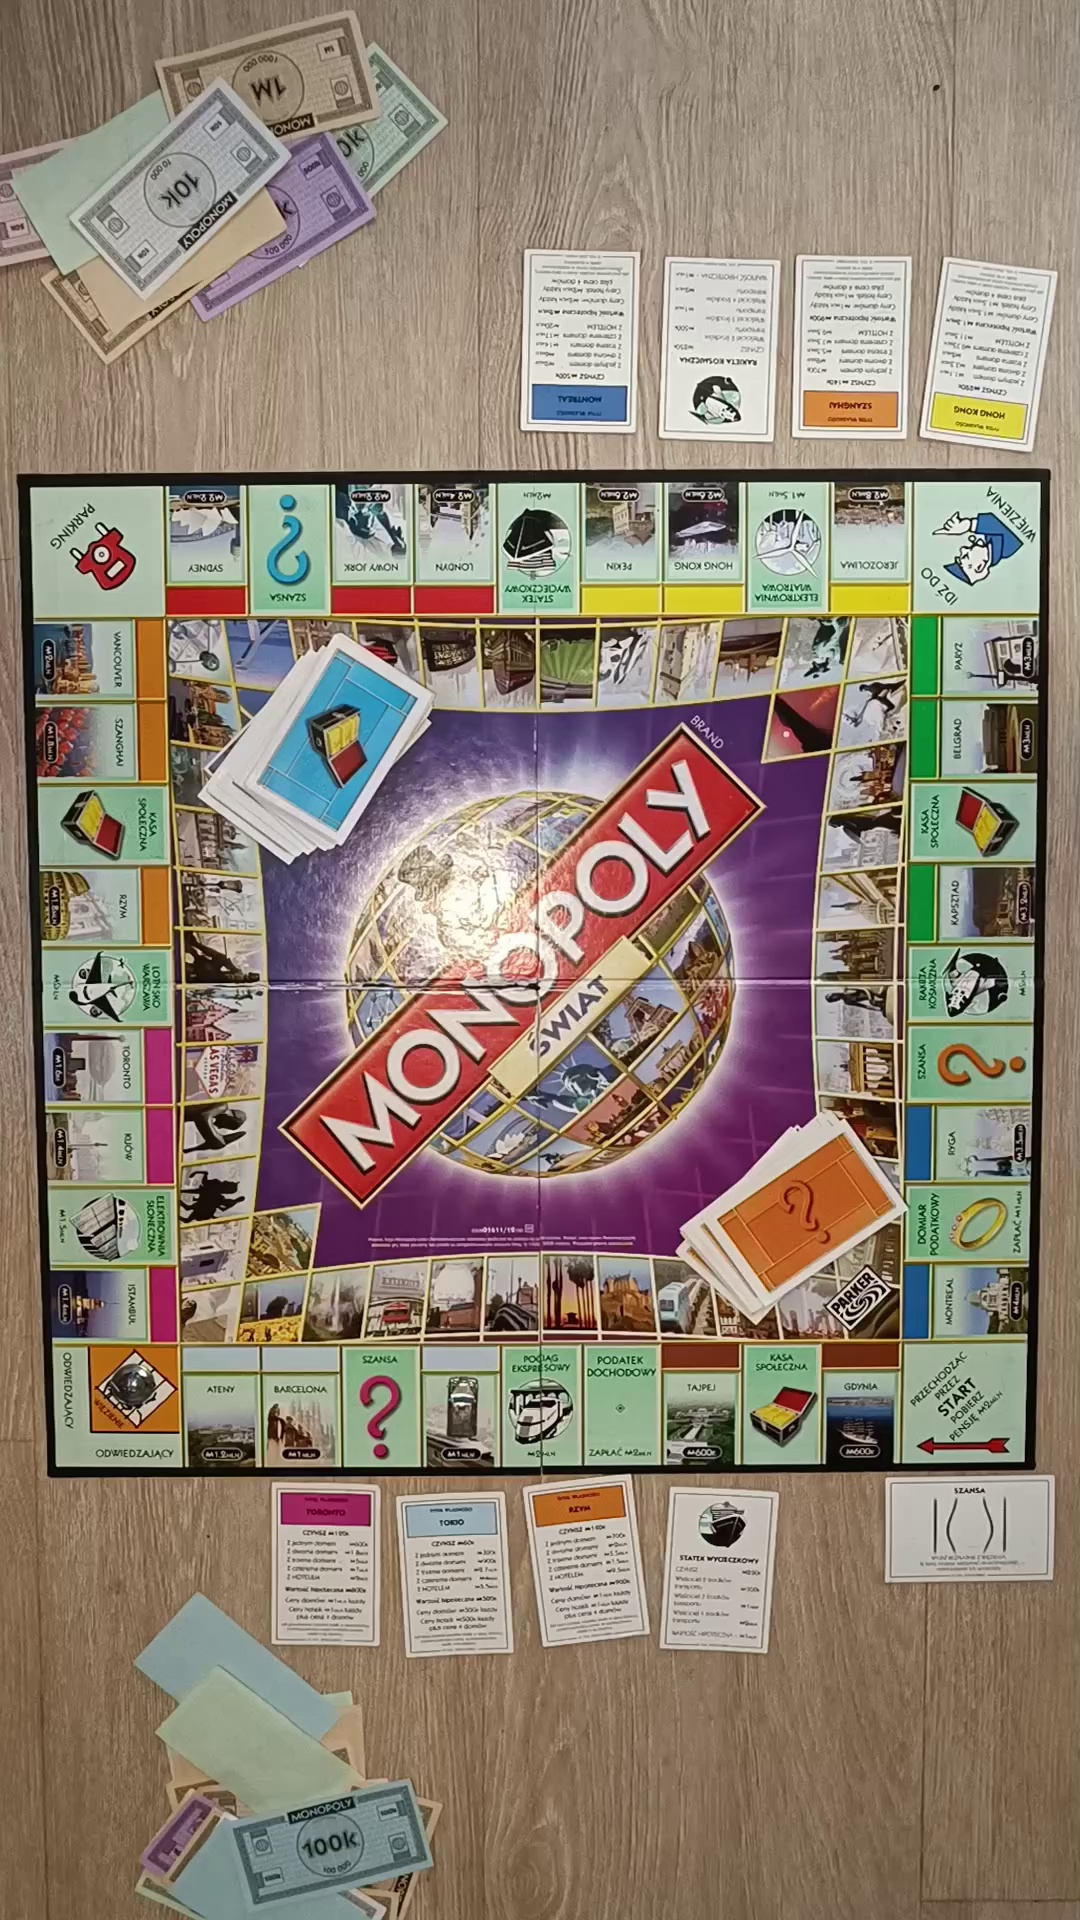

In [2]:
img = cv2.imread("data/images/rec_frame_c.jpg")
showarray(img)

8 / 81 contours


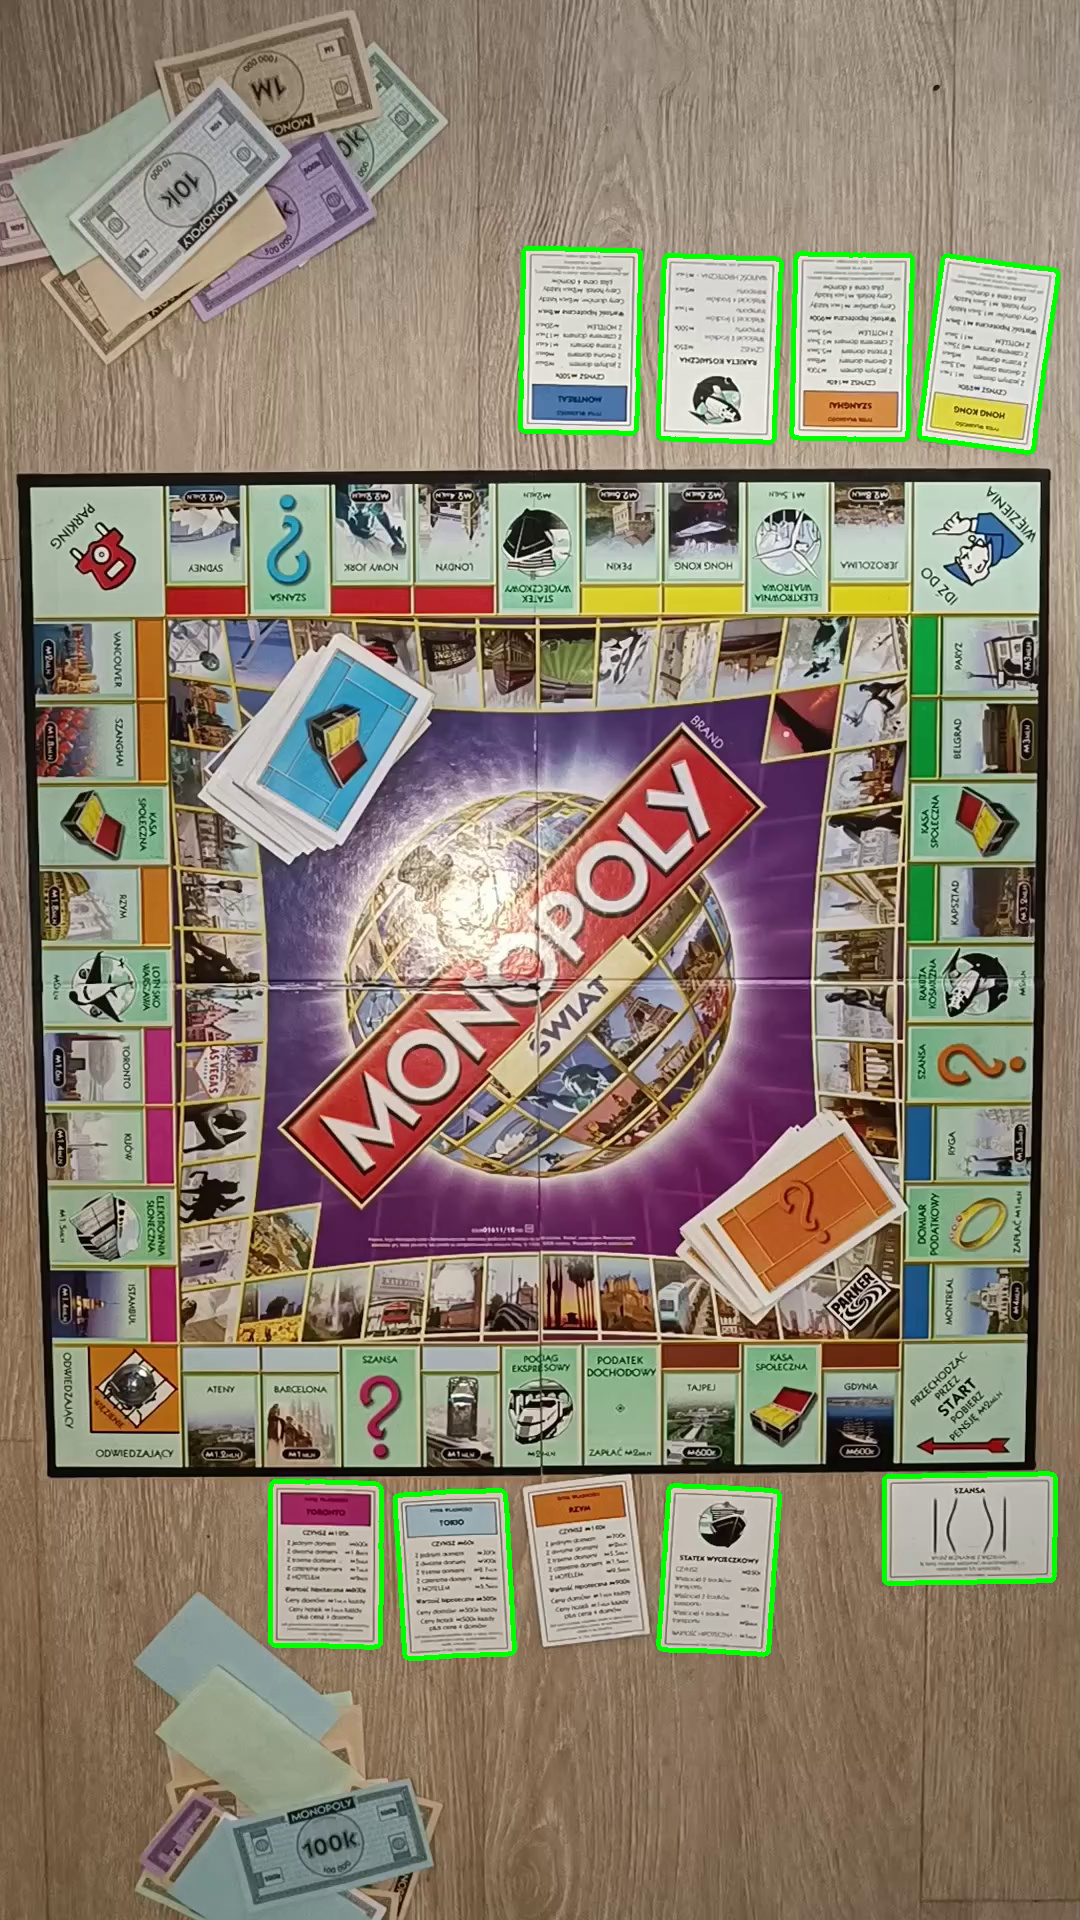

In [3]:
def get_clear_edges(img: np.ndarray):
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gs, (7, 7), 2)
    edges = cv2.Canny(img_blur, 100, 140)
    edges = cv2.dilate(edges, kernel=np.ones((3, 3), np.uint8))
    return edges

def is_min_area_in_bounds_and_good_edges_ratio(contour: np.ndarray, area_low: int, area_high: int, ratio: float) -> bool:
    min_rect = cv2.minAreaRect(contour)
    width = min_rect[1][0]
    height = min_rect[1][1]
    area =  width * height
    actual_ratio = max(width, height) / min(width, height)
    return area_low < area < area_high and abs(actual_ratio - ratio) < 0.1

CARD_RATIO = 8.5 / 5.5

def filter_contours(contours: list[np.ndarray]) -> list[np.ndarray]:
    return [
        contour 
        for contour in contours
        if cv2.contourArea(contour) > 600
        and is_min_area_in_bounds_and_good_edges_ratio(contour, 10_000, 25_000, CARD_RATIO)
    ]

edges = get_clear_edges(img)
contours, _ =cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = filter_contours(contours)
print(f"{len(filtered_contours)} / {len(contours)} contours")
img_with_contours = cv2.drawContours(img.copy(), filtered_contours, -1, (0, 255, 0), 3)
showarray(img_with_contours)

In [4]:
capture = cv2.VideoCapture("data/recordings/Easy_3.mp4")
cv2.namedWindow("Feed", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Feed", 400, 800)
while True:
    ret, frame = capture.read()
    if not ret:
        break
    edges = get_clear_edges(frame)
    contours, _ =cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter_contours(contours)
    frame = cv2.drawContours(frame, filtered_contours, -1, (0, 255, 0), 3)
    cv2.imshow('Feed', frame) 
    if cv2.waitKey(3) & 0xFF == ord('q'):
        break
capture.release()
cv2.destroyAllWindows()

In [6]:
def calculate_frame_similarity(frame_1: np.ndarray, frame_2: np.ndarray) -> float:
    if frame_1 is None:
        return 1
    last_frame_gs = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY) / 255
    current_frame_gs = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY) / 255
    last_frame_norm = last_frame_gs / np.sqrt(np.sum(last_frame_gs ** 2))
    current_frame_norm = current_frame_gs / np.sqrt(np.sum(current_frame_gs ** 2))
    return np.sum(last_frame_norm * current_frame_norm)

In [9]:
similarities = []
for i in range(1, 4):
    sim = []
    capture = cv2.VideoCapture(f"data/recordings/Easy_{i}.mp4")
    last_frame = None
    while True:
        ret, frame = capture.read()
        if not ret:
            break
        sim.append(calculate_frame_similarity(last_frame, frame))
        last_frame = frame
    similarities.append(sim)
    capture.release()

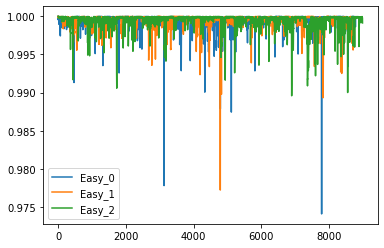

In [10]:
import matplotlib.pyplot as plt

for i, sim in enumerate(similarities):
    plt.plot(sim, label=f"Easy_{i}")
plt.legend()
plt.show()